In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg
from typing import Tuple
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import dump, load
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import seaborn as sns

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import Callback

from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

In [2]:
# GPU 할당량 조정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)]) # 1660super 총 vram 6gb 중 5.5gb 할당
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: int, kernel_size: int, neg_slope: float = .01, dropout: float = .5,
                 name: str = ''):
        super(InnerConv1DBlock, self).__init__(name=name)
        self.conv1d = tf.keras.layers.Conv1D(h * filters, kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class Exp(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exp, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)


class Split(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Split, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, ::2], inputs[:, 1::2]

class Attention(tf.keras.layers.Layer):

    def __init__(self, units=64, shape = (1,1,1), **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units=shape[2], use_bias = False, name='attention_score_vec')
        self.lambda_ = tf.keras.layers.Lambda(lambda x : x[:,-1,:], output_shape=(shape[2],),name='last_hidden_state')
        # x.mean(axis = 1) - image attention, 
        self.dot1 = tf.keras.layers.Dot(axes=[1, 2], name='attention_score')
        self.activation = tf.keras.layers.Activation('softmax', name='attention_weight')
        self.dot2 =  tf.keras.layers.Dot(axes=[1, 1], name='context_vector')
        self.concat =  tf.keras.layers.Concatenate(name='attention_output')
        self.dense2 = tf.keras.layers.Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        self.attention_weight = []

    def call(self, inputs):

        hidden_states = inputs

        score_first_part = self.dense1(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.lambda_(hidden_states)
        score =self.dot1([h_t, score_first_part]) # batch, time_stamps
        self.attention_weight = score # batch , time_stamps
        attention_weights = self.activation(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.dot2([hidden_states, attention_weights]) # batch_size, n_features
        pre_activation = self.concat([context_vector, h_t])
        attention_vector =self.dense2(pre_activation)
        return attention_vector, context_vector

    def get_config(self):
        return {'Attention_weights': self.attention_weight}



class SciBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size: int, h: int):
        super(SciBlock, self).__init__()
        self.kernel_size = kernel_size
        self.h = h

        self.split = Split()
        self.exp = Exp()

    def build(self, input_shape):
        _, _, filters = input_shape

        self.psi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='psi')
        self.phi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='phi')
        self.eta = InnerConv1DBlock(filters, self.h, self.kernel_size, name='eta')
        self.rho = InnerConv1DBlock(filters, self.h, self.kernel_size, name='rho')

    def call(self, input_tensor):
        F_odd, F_even = self.split(input_tensor)

        F_s_odd = F_odd * self.exp(self.phi(F_even))
        F_s_even = F_even * self.exp(self.psi(F_s_odd))

        F_prime_odd = F_s_odd + self.rho(F_s_even)
        F_prime_even = F_s_even - self.eta(F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    def __init__(self):
        super(Interleave, self).__init__()

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2

        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1]*2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, output_length: int, level: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), shape : Tuple[float, float, float] = (0, 0, 0)):
        super(SciNet, self).__init__()
        self.level = level
        self.h = h
        self.kernel_size = kernel_size
        self.max_nodes = 2 ** (level + 1) - 1

        self.sciblocks = [SciBlock(kernel_size, h) for _ in range(self.max_nodes)]
        self.interleave = Interleave()
        self.Attention = Attention(shape=shape)
        self.flatten = tf.keras.layers.Flatten()
        # self.dense1 = tf.keras.layers.Dense(100, kernel_regularizer=L1L2(0.001, 0.01))
        self.dense = tf.keras.layers.Dense(output_length, kernel_regularizer=L1L2(0.001, 0.01))
        self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

    def build(self, input_shape):
        assert input_shape[1] / 2 ** 1 % 1 == 0  # inputs must be evenly divided at the lowest level of the tree
        [layer.build(input_shape) for layer in self.sciblocks]
    @tf.function
    def call(self, input_tensor):
        # cascade input down a binary tree of sci-blocks
        inputs = [input_tensor]
        for i in range(self.level):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            outputs = [out for j, tensor in zip(range(i_start, i_end), inputs) for out in self.sciblocks[j](tensor)]
            inputs = outputs

        x = self.interleave(outputs)
        x += input_tensor

        x, attention_weights = self.Attention(x)
        # x = self.dense1(x)
        x = self.dense(x)

        # x = self.regularizer(x)
        return x, attention_weights

    def get_config(self):
        return {'Attention_layer': self.Attention}

In [4]:
class VisualizeAttentionMap(Callback):
    
    def __init__(self, model, x, weights):

        super().__init__()
        self.model = model
        self.x = x
        self.weights = weights
        self.activation = tf.keras.layers.Activation('softmax')

    def on_epoch_begin(self, epoch, logs=None):
        #input_ = self.model._feed_inputs[0]
        #output = self.activation(input)
        #test = tf.keras.models.Model(inputs= input, outputs = output)
        #x = test(self.x)
        #attention_map = tf.matmul(self.weights,x).numpy()
        #test.layers[1].set_weights(weights = self.weights)
        #test.layers[1]  = test.layers[1].output.from_tensor(tensor =tf.nn.softmax(self.weights))
        #attention_map = test(self.x).numpy()
        attention_map = tf.nn.softmax(tf.math.divide(self.weights,3), axis = 1) # softmax smoothing
        
        #x = self.x[..., 0]
        if epoch % 10 == 0 :
            plt.figure(figsize= (10,5))
            maps = [attention_map]
            maps_names = ['attention layer']
            plt.imshow(maps[0], cmap='jet')
            plt.show()

        return attention_map


def softmax_with_temperature(z, T) : 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axi) 
    exp_z = np.exp(z-max_z) 
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

In [5]:
def split_sequence(sequence, look_back_window: int, forecast_horizon: int, stride: int = 1):
    X, y = [], []
    for i in range(0, len(sequence), stride):
        # find the end x and y
        end_ix = i + look_back_window
        end_iy = end_ix + forecast_horizon

        # check if there is enough elements to fill this x, y pair
        if end_iy > len(sequence):
            break

        X.append(sequence[i:end_ix])
        y.append(sequence[end_iy - 1 if forecast_horizon == 1 else end_ix:end_iy])
    return np.asarray(X), np.asarray(y)


class StocksImputer(TransformerMixin):
    def __init__(self, method: str = 'linear', fail_save: TransformerMixin = SimpleImputer()):
        self.method = method
        self.fail_save = fail_save

    def fit(self, data):
        if self.fail_save:
            self.fail_save.fit(data)
        return self

    def transform(self, data):
        # Interpolate missing values in columns
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        data = data.interpolate(method=self.method, limit_direction='both')
        # spline or time may be better?

        if self.fail_save:
            data = self.fail_save.transform(data)

        return data


def difference(dataset, interval=1, relative=False, min_price=1e-04):
    delta = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        if relative:
            prev_price = dataset[i - interval]
            prev_price[prev_price == 0] = min_price
            value /= prev_price
        delta.append(value)
    return np.asarray(delta)


class ARIMAPreprocessor(TransformerMixin):
    def __init__(self, y_col: str, look_back_window: int, forecast_horizon: int, stride: int, diff_order: int,
                 relative_diff: bool = True, splitXy: bool = True, scaling: str = 'minmax'):
        super().__init__()
        assert look_back_window > 0 and forecast_horizon > 0 and stride > 0

        self.y_col = y_col
        self.y_idx = None
        self.look_back_window = look_back_window
        self.forecast_horizon = forecast_horizon
        self.stride = stride
        self.diff_order = diff_order
        self.relative_diff = relative_diff
        self.splitXy = splitXy
        self.interpolation_imputer = StocksImputer(method='linear')

        if scaling == 'minmax':
            self.scaler = MinMaxScaler()
            self.y_scaler = MinMaxScaler()
        elif scaling == 'standard':
            self.scaler = StandardScaler()
            self.y_scaler = StandardScaler()
        elif scaling == 'robust':
            self.scaler = RobustScaler()
            self.y_scaler = RobustScaler()

    def fit_transform(self, data, **fit_params):
        self.y_idx = list(data.columns).index(self.y_col)

        # Fill missing values via interpolation
        data = self.interpolation_imputer.fit_transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        self.y_scaler.fit(data[:, self.y_idx].reshape(-1, 1))  # for reversing scaling post prediction
        data = self.scaler.fit_transform(data)

        if not self.splitXy:
            return data

        # Extract X, y from time series
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y, self.scaler

    def transform(self, data):
        # Fill missing values via interpolation
        data = self.interpolation_imputer.transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        data = self.scaler.transform(data)

        if not self.splitXy:
            return data

        # Extract X, y
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y

In [6]:
# Make model
def make_model(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def make_model_2(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    #tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
    #             metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [7]:
# Hyper Parametres
y_col = '일별배출량합계'
index_col = '일자'
cluster_num = 4

data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')

EPOCHS = 100

degree_of_differencing = 0
look_back_window, forecast_horizon = 60*2 * (data.읍면동.nunique()), 62 * (data.읍면동.nunique()) #전에 몇개의 데이터 참조, 후에 몇개 예측
batch_size = 64
learning_rate = 9e-5
h, kernel_size, level = 4, 5, 3
#stride = look_back_window + forecast_horizon  # unsure if any value lower than this would cause data leak

data = data.sort_values(by = ['일자','읍면동'])
data['일자'] = pd.to_datetime(data['일자'])
data = data.set_index(keys = '일자')
data = data.loc["2019-11-07":, : ]

In [8]:
train = data[:-look_back_window]
final_test_data = data[-look_back_window:]

In [9]:
data.drop(['읍면동'], axis=1, inplace=True)

In [10]:
train.drop(['읍면동'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
train_data = train[:int(0.80 * (len(train) - (look_back_window + forecast_horizon)))]   #train_data = train[:int(0.6 * len(data))]
val_data = train[int(0.80 * (len(train) - (look_back_window + forecast_horizon))):-look_back_window + forecast_horizon]
test_data = train[-(look_back_window + forecast_horizon):]

In [12]:
train_data.shape, val_data.shape, test_data.shape

((1920, 24), (1472, 24), (1456, 24))

In [13]:
look_back_window + forecast_horizon

1456

In [14]:
# Train model
preprocessor = ARIMAPreprocessor(y_col, look_back_window, forecast_horizon, 1, degree_of_differencing,
                                  relative_diff=True, scaling='standard')
X_train, y_train, scaler = preprocessor.fit_transform(train_data)
X_val, y_val = preprocessor.transform(val_data)
print(f'Input shape: X{X_train.shape}, y{y_train.shape}')

Input shape: X(465, 960, 24), y(465, 496)


In [15]:
model = make_model_2(batch_size, X_train.shape[1], X_train.shape[2])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 960, 24)]         0         
_________________________________________________________________
sci_net (SciNet)             ((None, 496), (None, 24)) 684368    
Total params: 684,368
Trainable params: 684,368
Non-trainable params: 0
_________________________________________________________________


In [16]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean()

val_loss = tf.keras.metrics.Mean()

train_loss_list = []
val_loss_list = []


def train_function(train_X, train_y):
    with tf.GradientTape() as tape:
     
        predictions, attention_weights = model(train_X)
       
        loss = loss_function(train_y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    mse = tf.keras.metrics.mse(train_y, predictions)
    mae = tf.keras.metrics.mae(train_y, predictions)

    return loss, mse, mae, attention_weights

def test_function(val_X, val_y):

    predictions, _ = model(val_X)
 
    loss = loss_function(val_y, predictions)

    val_loss(loss)
    mse = tf.keras.metrics.mse(val_y, predictions)
    mae = tf.keras.metrics.mae(val_y, predictions)

    return loss, mse, mae


In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [18]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

폴더가 이미 존재


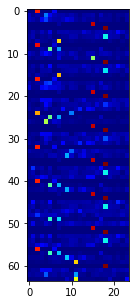

epochs: 1/100, train loss : 1.06964 train mse: 1.06964 train mae: 0.81049  validation loss: 0.99621 validation mse : 0.99621 validation mae: 0.77399
epochs: 2/100, train loss : 1.04505 train mse: 1.02047 train mae: 0.79057  validation loss: 0.98543 validation mse : 0.97465 validation mae: 0.76555
epochs: 3/100, train loss : 1.02350 train mse: 0.98038 train mae: 0.77514  validation loss: 0.97420 validation mse : 0.95175 validation mae: 0.75583
epochs: 4/100, train loss : 1.00483 train mse: 0.94885 train mae: 0.76270  validation loss: 0.96323 validation mse : 0.93033 validation mae: 0.74557
epochs: 5/100, train loss : 0.98806 train mse: 0.92098 train mae: 0.75086  validation loss: 0.95246 validation mse : 0.90936 validation mae: 0.73734
epochs: 6/100, train loss : 0.97231 train mse: 0.89357 train mae: 0.73957  validation loss: 0.94405 validation mse : 0.90203 validation mae: 0.73537
epochs: 7/100, train loss : 0.95750 train mse: 0.86864 train mae: 0.72905  validation loss: 0.93609 valida

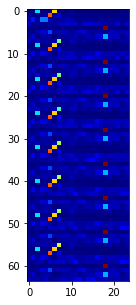

epochs: 11/100, train loss : 0.90419 train mse: 0.77778 train mae: 0.69029  validation loss: 0.90854 validation mse : 0.83107 validation mae: 0.70705
epochs: 12/100, train loss : 0.89197 train mse: 0.75756 train mae: 0.68110  validation loss: 0.90069 validation mse : 0.81437 validation mae: 0.69954
epochs: 13/100, train loss : 0.88001 train mse: 0.73649 train mae: 0.67195  validation loss: 0.89375 validation mse : 0.81051 validation mae: 0.69811
epochs: 14/100, train loss : 0.86827 train mse: 0.71563 train mae: 0.66296  validation loss: 0.88687 validation mse : 0.79737 validation mae: 0.69225
epochs: 15/100, train loss : 0.85672 train mse: 0.69514 train mae: 0.65363  validation loss: 0.88011 validation mse : 0.78552 validation mae: 0.68720
epochs: 16/100, train loss : 0.84536 train mse: 0.67494 train mae: 0.64391  validation loss: 0.87323 validation mse : 0.77006 validation mae: 0.68045
epochs: 17/100, train loss : 0.83418 train mse: 0.65527 train mae: 0.63433  validation loss: 0.86654

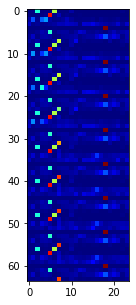

epochs: 21/100, train loss : 0.79100 train mse: 0.57973 train mae: 0.59666  validation loss: 0.83814 validation mse : 0.68666 validation mae: 0.64416
epochs: 22/100, train loss : 0.78060 train mse: 0.56212 train mae: 0.58762  validation loss: 0.83073 validation mse : 0.67506 validation mae: 0.63908
epochs: 23/100, train loss : 0.77035 train mse: 0.54491 train mae: 0.57853  validation loss: 0.82343 validation mse : 0.66281 validation mae: 0.63301
epochs: 24/100, train loss : 0.76026 train mse: 0.52811 train mae: 0.56947  validation loss: 0.81624 validation mse : 0.65085 validation mae: 0.62726
epochs: 25/100, train loss : 0.75032 train mse: 0.51180 train mae: 0.56055  validation loss: 0.80916 validation mse : 0.63919 validation mae: 0.62157
epochs: 26/100, train loss : 0.74053 train mse: 0.49592 train mae: 0.55167  validation loss: 0.80211 validation mse : 0.62589 validation mae: 0.61522
epochs: 27/100, train loss : 0.73090 train mse: 0.48045 train mae: 0.54289  validation loss: 0.79507

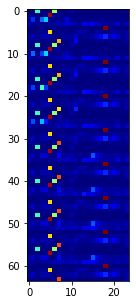

epochs: 31/100, train loss : 0.69388 train mse: 0.42288 train mae: 0.50881  validation loss: 0.76785 validation mse : 0.56575 validation mae: 0.58526
epochs: 32/100, train loss : 0.68499 train mse: 0.40954 train mae: 0.50055  validation loss: 0.76113 validation mse : 0.55282 validation mae: 0.57888
epochs: 33/100, train loss : 0.67625 train mse: 0.39661 train mae: 0.49241  validation loss: 0.75448 validation mse : 0.54144 validation mae: 0.57302
epochs: 34/100, train loss : 0.66766 train mse: 0.38407 train mae: 0.48438  validation loss: 0.74799 validation mse : 0.53402 validation mae: 0.56951
epochs: 35/100, train loss : 0.65923 train mse: 0.37255 train mae: 0.47684  validation loss: 0.74159 validation mse : 0.52377 validation mae: 0.56430
epochs: 36/100, train loss : 0.65103 train mse: 0.36419 train mae: 0.47156  validation loss: 0.73536 validation mse : 0.51747 validation mae: 0.56077
epochs: 37/100, train loss : 0.64296 train mse: 0.35256 train mae: 0.46387  validation loss: 0.72920

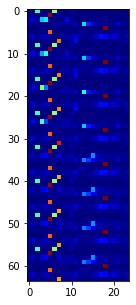

epochs: 41/100, train loss : 0.61182 train mse: 0.30780 train mae: 0.43218  validation loss: 0.70510 validation mse : 0.46928 validation mae: 0.53525
epochs: 42/100, train loss : 0.60435 train mse: 0.29809 train mae: 0.42504  validation loss: 0.69930 validation mse : 0.46131 validation mae: 0.53098
epochs: 43/100, train loss : 0.59701 train mse: 0.28873 train mae: 0.41808  validation loss: 0.69359 validation mse : 0.45382 validation mae: 0.52688
epochs: 44/100, train loss : 0.58980 train mse: 0.27972 train mae: 0.41123  validation loss: 0.68800 validation mse : 0.44746 validation mae: 0.52358
epochs: 45/100, train loss : 0.58271 train mse: 0.27105 train mae: 0.40449  validation loss: 0.68251 validation mse : 0.44128 validation mae: 0.52027
epochs: 46/100, train loss : 0.57576 train mse: 0.26271 train mae: 0.39792  validation loss: 0.67714 validation mse : 0.43528 validation mae: 0.51708
epochs: 47/100, train loss : 0.56893 train mse: 0.25467 train mae: 0.39153  validation loss: 0.67188

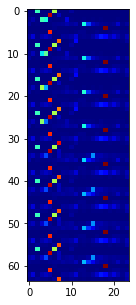

epochs: 51/100, train loss : 0.54282 train mse: 0.22570 train mae: 0.36753  validation loss: 0.65194 validation mse : 0.40995 validation mae: 0.50669
epochs: 52/100, train loss : 0.53659 train mse: 0.21893 train mae: 0.36181  validation loss: 0.64727 validation mse : 0.40878 validation mae: 0.50613
epochs: 53/100, train loss : 0.53048 train mse: 0.21263 train mae: 0.35647  validation loss: 0.64271 validation mse : 0.40562 validation mae: 0.50438
epochs: 54/100, train loss : 0.52448 train mse: 0.20635 train mae: 0.35082  validation loss: 0.63824 validation mse : 0.40120 validation mae: 0.50202
epochs: 55/100, train loss : 0.51858 train mse: 0.20037 train mae: 0.34525  validation loss: 0.63384 validation mse : 0.39665 validation mae: 0.49940
epochs: 56/100, train loss : 0.51280 train mse: 0.19464 train mae: 0.33998  validation loss: 0.62953 validation mse : 0.39255 validation mae: 0.49701
epochs: 57/100, train loss : 0.50712 train mse: 0.18913 train mae: 0.33497  validation loss: 0.62531

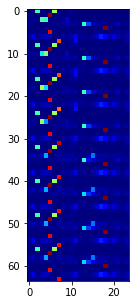

epochs: 61/100, train loss : 0.48544 train mse: 0.16920 train mae: 0.31586  validation loss: 0.60958 validation mse : 0.38500 validation mae: 0.49281
epochs: 62/100, train loss : 0.48026 train mse: 0.16468 train mae: 0.31139  validation loss: 0.60592 validation mse : 0.38289 validation mae: 0.49153
epochs: 63/100, train loss : 0.47519 train mse: 0.16034 train mae: 0.30703  validation loss: 0.60234 validation mse : 0.37988 validation mae: 0.48970
epochs: 64/100, train loss : 0.47020 train mse: 0.15616 train mae: 0.30279  validation loss: 0.59880 validation mse : 0.37638 validation mae: 0.48755
epochs: 65/100, train loss : 0.46531 train mse: 0.15215 train mae: 0.29865  validation loss: 0.59533 validation mse : 0.37286 validation mae: 0.48535
epochs: 66/100, train loss : 0.46050 train mse: 0.14828 train mae: 0.29464  validation loss: 0.59192 validation mse : 0.37008 validation mae: 0.48350
epochs: 67/100, train loss : 0.45579 train mse: 0.14457 train mae: 0.29072  validation loss: 0.58859

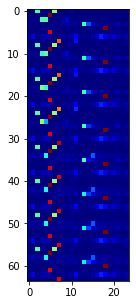

epochs: 71/100, train loss : 0.43777 train mse: 0.13105 train mae: 0.27609  validation loss: 0.57595 validation mse : 0.36251 validation mae: 0.47782
epochs: 72/100, train loss : 0.43347 train mse: 0.12796 train mae: 0.27266  validation loss: 0.57297 validation mse : 0.36148 validation mae: 0.47719
epochs: 73/100, train loss : 0.42924 train mse: 0.12497 train mae: 0.26931  validation loss: 0.57006 validation mse : 0.36037 validation mae: 0.47655
epochs: 74/100, train loss : 0.42509 train mse: 0.12210 train mae: 0.26611  validation loss: 0.56720 validation mse : 0.35812 validation mae: 0.47505
epochs: 75/100, train loss : 0.42101 train mse: 0.11935 train mae: 0.26296  validation loss: 0.56439 validation mse : 0.35634 validation mae: 0.47385
epochs: 76/100, train loss : 0.41701 train mse: 0.11671 train mae: 0.25984  validation loss: 0.56164 validation mse : 0.35577 validation mae: 0.47360
epochs: 77/100, train loss : 0.41308 train mse: 0.11418 train mae: 0.25687  validation loss: 0.55896

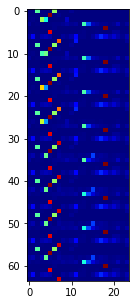

epochs: 81/100, train loss : 0.39803 train mse: 0.10497 train mae: 0.24573  validation loss: 0.54895 validation mse : 0.35655 validation mae: 0.47503
epochs: 82/100, train loss : 0.39443 train mse: 0.10288 train mae: 0.24314  validation loss: 0.54660 validation mse : 0.35645 validation mae: 0.47514
epochs: 83/100, train loss : 0.39089 train mse: 0.10087 train mae: 0.24061  validation loss: 0.54431 validation mse : 0.35637 validation mae: 0.47517
epochs: 84/100, train loss : 0.38741 train mse: 0.09893 train mae: 0.23815  validation loss: 0.54209 validation mse : 0.35781 validation mae: 0.47615
epochs: 85/100, train loss : 0.38400 train mse: 0.09708 train mae: 0.23578  validation loss: 0.53992 validation mse : 0.35750 validation mae: 0.47593
epochs: 86/100, train loss : 0.38064 train mse: 0.09529 train mae: 0.23346  validation loss: 0.53779 validation mse : 0.35719 validation mae: 0.47580
epochs: 87/100, train loss : 0.37734 train mse: 0.09356 train mae: 0.23120  validation loss: 0.53571

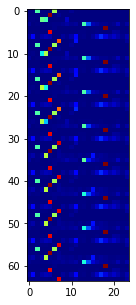

epochs: 91/100, train loss : 0.36469 train mse: 0.08727 train mae: 0.22275  validation loss: 0.52780 validation mse : 0.35480 validation mae: 0.47427
epochs: 92/100, train loss : 0.36166 train mse: 0.08585 train mae: 0.22078  validation loss: 0.52591 validation mse : 0.35427 validation mae: 0.47396
epochs: 93/100, train loss : 0.35868 train mse: 0.08446 train mae: 0.21885  validation loss: 0.52406 validation mse : 0.35355 validation mae: 0.47349
epochs: 94/100, train loss : 0.35575 train mse: 0.08314 train mae: 0.21699  validation loss: 0.52224 validation mse : 0.35294 validation mae: 0.47310
epochs: 95/100, train loss : 0.35287 train mse: 0.08185 train mae: 0.21516  validation loss: 0.52045 validation mse : 0.35225 validation mae: 0.47266
epochs: 96/100, train loss : 0.35003 train mse: 0.08061 train mae: 0.21339  validation loss: 0.51869 validation mse : 0.35174 validation mae: 0.47236
epochs: 97/100, train loss : 0.34724 train mse: 0.07942 train mae: 0.21165  validation loss: 0.51696

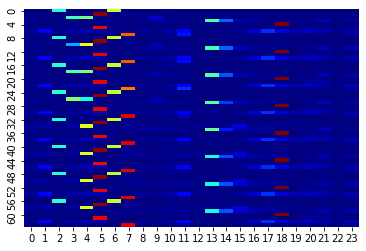

In [19]:
try :
    os.mkdir(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1')
except:
    print("폴더가 이미 존재")

visual_list = []
for epoch in range(EPOCHS):
    epoch_train_mse = 0
    epoch_train_mae = 0
    
    epoch_val_mse = 0
    epoch_val_mae = 0

    train_data_len = 0
    val_data_len = 0

    for train_X, train_y in train_dataset:
        _, train_mse, train_mae, attention_weights = train_function(train_X, train_y)
        train_data_len += 1
        epoch_train_mse += tf.reduce_mean(train_mse).numpy()
        epoch_train_mae += tf.reduce_mean(train_mae).numpy()
    for test_images, test_labels in val_dataset:
        _, val_mse, val_mae = test_function(test_images, test_labels)
        val_data_len += 1
        epoch_val_mse += tf.reduce_mean(val_mse).numpy()
        epoch_val_mae += tf.reduce_mean(val_mae).numpy()

    train_loss_list.append(train_loss.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    visual_result = VisualizeAttentionMap(model, train_X, attention_weights).on_epoch_begin(epoch)
    visual_list.append(visual_result.numpy())
    template = 'epochs: {}/{}, train loss : {:.5f} train mse: {:.5f} train mae: {:.5f}  validation loss: {:.5f} validation mse : {:.5f} validation mae: {:.5f}'
    print(template.format(epoch+1,
                         EPOCHS,
                         train_loss.result().numpy(),
                         epoch_train_mse / train_data_len,
                         epoch_train_mae / train_data_len,
                         val_loss.result().numpy(),
                         epoch_val_mse / val_data_len,
                         epoch_val_mae / val_data_len))
  
    if (epoch+1) % 10 == 0 :
        model.save_weights(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1/model_{epoch+1}.pth') 



try :
    os.mkdir(f'../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1')
except:
    print("폴더가 이미 존재")

for idx, img in enumerate(visual_list) :
    tmp = sns.heatmap(img, cmap ='jet', cbar = False)
    tmp.figure.savefig(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1/{idx}.png")
    
    
    
path = [f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1/{i}" for i in os.listdir(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1") if i.endswith(".png")]
paths = [np.array(Image.open(i)) for i in path]

try :
    os.mkdir(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1')
except :
    print("폴더가 이미 존재")
    
imageio.mimsave(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_1/result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}.gif', paths, fps=5)

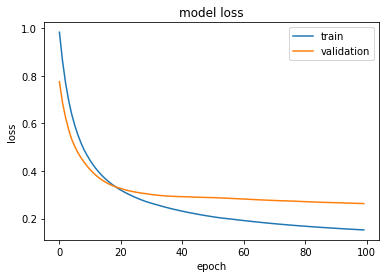

In [23]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

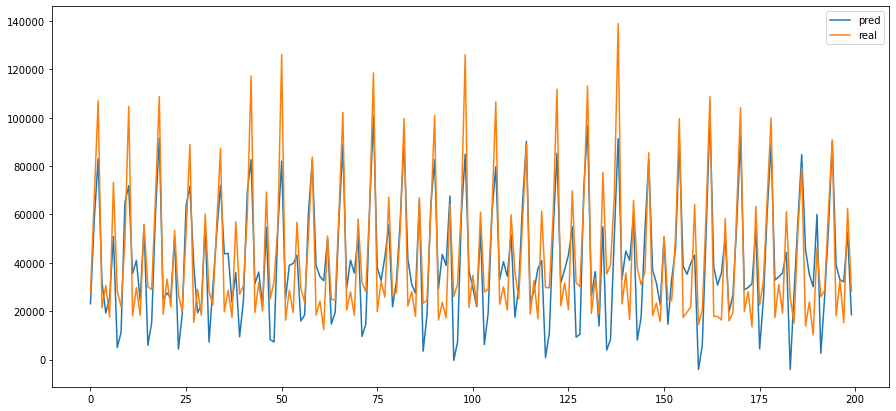

In [23]:
plt.figure(figsize=(15,7))
plt.plot(comparison[200:400])
plt.legend(['pred','real'])
plt.show()

In [24]:
data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
final_test_data = data[-look_back_window:]

In [25]:
final_dong_list = final_test_data.읍면동.unique()
final_test_data.drop(columns = '읍면동', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
a = scaler.transform(final_test_data)

In [33]:
np.asarray([a]).shape

(1, 960, 24)

In [34]:
y_pred,_ = model.predict(np.asarray([a]))

In [35]:
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [37]:
list(final_dong_list)

['구좌읍', '남원읍', '대정읍', '송산동', '천지동', '한경면', '한림읍', '효돈동']

In [38]:
final_dong_cluster_0 = list(final_dong_list) * int(y_pred.shape[0] / len(final_dong_list))

In [39]:
final_result = pd.DataFrame(np.vstack([final_dong_cluster_0,np.reshape(y_pred, (y_pred.shape[0]))]).T, columns=['읍면동','7_8월예측값'])

In [40]:
final_result[final_result['7_8월예측값'].astype('float') < 0 ] #음수값이 있나 확인

,읍면동,7_8월예측값
87,효돈동,-1008.0672


In [39]:
final_result.to_csv(f'../data/processed_data/cluster_{cluster_num}_final_result.csv', encoding = 'cp949', index = False)